<a href="https://colab.research.google.com/github/thien2001git/HoangXuanThienDoAnTotNghiep/blob/main/LabelTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 33.3 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
import pandas as pd
import tensorflow_io as tfio
from keras import layers
from keras import models
import os
import librosa
import pickle
from IPython.display import Audio
from IPython.core.display import display
import random
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


* getAllFile(root): lấy tên các file từ đường dẫn folder
* dumpToFile(obj, path): lưu đối tượng dạng file nhị phân
* loadToObj(path): lấy file nhị phân về đối tượng


In [3]:
def getAllFile(root):
    l = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            l.append(os.path.join(path, name))
    return l
def dumpToFile(obj, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)
def loadToObj(path):
    with open(path, 'rb') as file:
        return pickle.load(file)


Lấy sẵn tên file

In [4]:
# distant_16k = getAllFile('drive/MyDrive/VOiCES_devkit/distant-16k/')
# source_16k = getAllFile('drive/MyDrive/VOiCES_devkit/source-16k/train')
# references = getAllFile('drive/MyDrive/VOiCES_devkit/references/')
# speech = getAllFile('/content/drive/MyDrive/VOiCES_devkit/distant-16k/speech/train')
# source_16k = getAllFile('drive/MyDrive/VOiCES_devkit/source-16k/test')
# speech = getAllFile('/content/drive/MyDrive/VOiCES_devkit/distant-16k/speech/test')

Lưu tên file ra file riêng

In [5]:
# dumpToFile(distant_16k, "drive/MyDrive/distant_16k.bin")
# dumpToFile(source_16k, "drive/MyDrive/source_16k_train.bin")
# dumpToFile(speech, "drive/MyDrive/speech_train.bin")
# dumpToFile(source_16k, "drive/MyDrive/source_16k_test.bin")
# dumpToFile(speech, "drive/MyDrive/speech_test.bin")

Lấy tên các file âm thanh

In [6]:
path = ["drive/MyDrive/distant_16k.bin",
        "drive/MyDrive/source_16k_train.bin",
        'drive/MyDrive/speech_train.bin',
        "drive/MyDrive/source_16k_test.bin",
        "drive/MyDrive/speech_test.bin", ]
# distant_16k = loadToObj(path[0])
source_16k_train = loadToObj(path[1])
speech_train = loadToObj(path[2])
source_16k_test = loadToObj(path[3])
speech_test = loadToObj(path[4])

In [7]:
random.shuffle(speech_train)
random.shuffle(speech_test)

In độ dài các danh sách

In [8]:
# print(len(distant_16k))
print(len(source_16k_train))
print(len(speech_train))
print(len(source_16k_test))
print(len(speech_test))

400
12800
200
6400


Định nghĩa biến toàn cục

In [9]:
hop_length = int(math.pow(2,10))

Phương thức hiển thị đồ thị âm thanh

In [10]:
def showSome(path):
    y, sr = librosa.load(path)
    librosa.display.waveshow(y)
    plt.show()
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                                ref=np.max)
    img = librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                            x_axis='time')


Tệp có tiếng ồn

/content/drive/MyDrive/VOiCES_devkit/distant-16k/speech/train/rm2/tele/sp8108/Lab41-SRI-VOiCES-rm2-tele-sp8108-ch274318-sg0029-mc01-stu-clo-dg170.wav


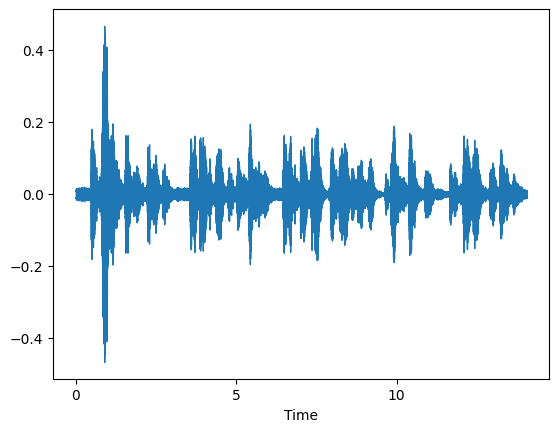

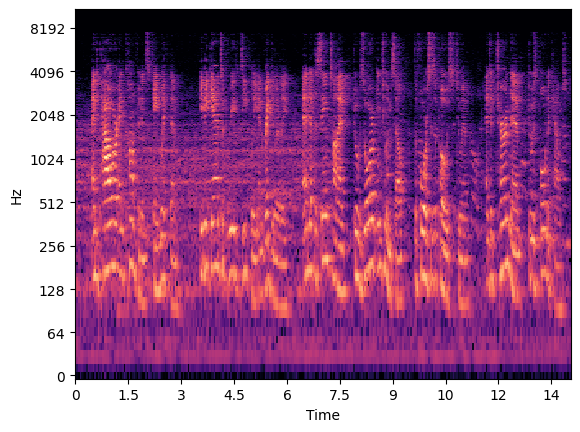

In [11]:
# noise
print(speech_train[0])
showSome(speech_train[0])

Tệp không có tiếng ồn

drive/MyDrive/VOiCES_devkit/source-16k/train/sp8425/Lab41-SRI-VOiCES-src-sp8425-ch246962-sg0014.wav


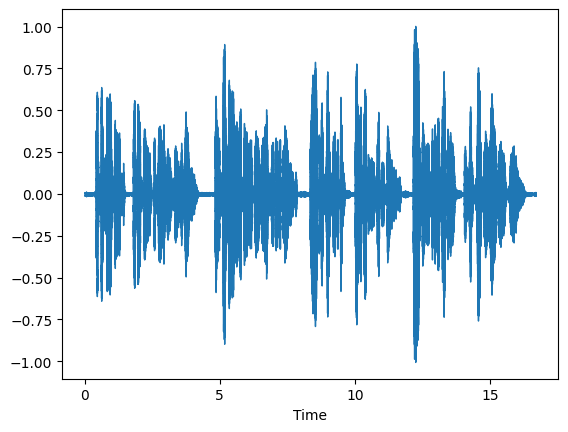

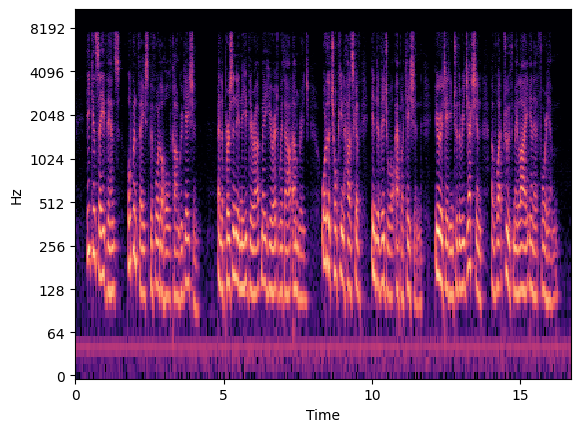

In [12]:
print(source_16k_train[0])
showSome(source_16k_train[0])

Phương thức tạo label từ tên file

In [13]:
def toLabel(ele):
    l1 = ele.split("/")
    l2 = l1[len(l1) - 1].split("-")
    # for i, e in enumerate(l2):
    #     print("{} {}".format(i, e))
    lb = dict()
    lb[l2[4]] = 1
    lb["mc"] = int(l2[8].replace("mc", ""))
    # lb[l2[9]] = 1
    lb[l2[10]] = 1
    lb["dg"] = int(l2[11].replace("dg", "").replace(".wav", ""))
    return lb
    


Lấy label từ tên các file ra danh sách

In [14]:
label_train = []
label_test = []
for i in speech_train:
  label_train.append(toLabel(i))
for i in speech_test:
  label_test.append(toLabel(i))

In [15]:
print(len(label_train))
print(len(label_test))

12800
6400


Lấy tât cả label có thể có

In [16]:
all_lb = dict()
for i in label_train:
  for k in i:
    all_lb[k] = 0
for i in label_test:
  for k in i:
    all_lb[k] = 0
all_lb

{'tele': 0,
 'mc': 0,
 'clo': 0,
 'dg': 0,
 'none': 0,
 'far': 0,
 'musi': 0,
 'babb': 0}

Phương thức Đưa các label chưa có vào label đã có để cùng kiểu

In [17]:
def toAllLabel(ele):
  for i in range(len(ele)):
    for j in all_lb:
      if j not in ele[i]:
        ele[i][j] = 0

Đưa các label chưa có vào label đã có để cùng kiểu

In [18]:
toAllLabel(label_train)
toAllLabel(label_test)

In [19]:
df = pd.DataFrame(label_train)

In [20]:
df

,tele,mc,clo,dg,none,far,musi,babb
0,1,1,1,170,0,0,0,0
1,0,5,0,170,1,1,0,0
2,0,1,1,140,0,0,1,0
3,1,1,1,110,0,0,0,0
4,1,1,1,80,0,0,0,0
...,...,...,...,...,...,...,...,...
12795,1,5,0,140,0,1,0,0
12796,0,5,0,110,0,1,0,1
12797,0,1,1,160,0,0,1,0
12798,0,5,0,160,1,1,0,0


In [21]:
def toCateNoise(lb):
  new_lb = []
  for i in lb:
    if i['babb'] == 1:
      new_lb.append(0)
    if i['musi'] == 1:
      new_lb.append(1)
    if i['none'] == 1:
      new_lb.append(2)
    if i['tele'] == 1:
      new_lb.append(3)
  return new_lb

def toDistant(lb):
  new_lb = []
  for i in lb:
    if i['clo'] == 1:
      new_lb.append(0)
    if i['far'] == 1:
      new_lb.append(1)
  return new_lb

In [22]:
cate_train = toCateNoise(label_train)
cate_test = toCateNoise(label_test)
distant_train = toDistant(label_train)
distant_test = toDistant(label_test)

In [23]:
print(cate_train)
print(distant_train)

[3, 2, 1, 3, 3, 3, 2, 0, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 2, 1, 3, 1, 3, 0, 2, 2, 0, 0, 3, 2, 1, 2, 2, 2, 2, 0, 3, 1, 1, 3, 3, 0, 0, 3, 1, 0, 0, 2, 1, 0, 1, 0, 1, 0, 3, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 3, 2, 0, 3, 2, 2, 0, 2, 0, 1, 3, 3, 2, 2, 3, 1, 1, 0, 1, 3, 2, 3, 3, 3, 2, 1, 3, 2, 2, 2, 2, 2, 2, 3, 2, 0, 1, 2, 2, 1, 2, 1, 3, 2, 2, 3, 0, 3, 0, 2, 2, 3, 2, 1, 2, 1, 3, 0, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 0, 3, 2, 2, 2, 0, 1, 0, 1, 3, 2, 3, 2, 2, 1, 3, 2, 0, 2, 1, 0, 3, 1, 2, 3, 2, 2, 2, 2, 3, 3, 0, 3, 2, 3, 3, 3, 2, 0, 1, 1, 3, 1, 0, 0, 0, 3, 3, 2, 2, 0, 1, 2, 0, 0, 1, 1, 1, 2, 3, 2, 1, 3, 0, 1, 0, 1, 1, 3, 0, 0, 3, 0, 1, 0, 3, 2, 1, 1, 1, 2, 2, 2, 0, 3, 1, 2, 3, 1, 1, 3, 3, 1, 1, 0, 1, 1, 0, 2, 0, 1, 2, 2, 2, 2, 3, 0, 3, 3, 0, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 0, 0, 2, 1, 1, 0, 3, 0, 2, 2, 2, 1, 0, 2, 1, 0, 2, 2, 3, 3, 0, 1, 2, 3, 2, 0, 1, 3, 2, 0, 2, 1, 1, 3, 2, 1, 2, 1, 1, 2, 2, 3, 3, 2, 3, 0, 1, 2, 1, 2, 0, 3, 0, 2, 1, 3, 3, 0, 2, 1, 1, 1, 2, 3, 1, 1, 2, 3, 2, 2, 1, 1, 0, 0, 3, 2, 

In [24]:
def load(file):
    y, sr = librosa.load(file, sr = 16000)
    y = y[:16000*16]
    zr = np.zeros((16000*16 - y.shape[0]))
    y = np.append(y, zr)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())
    return spectrogram


In [25]:
# duoi = 1000 * 1
# tren = 1000 * 2
# X_train = [load(i) for i in speech_train[duoi:tren]]

In [26]:
X_test = [load(i) for i in speech_test[:200]]

Text(0.5, 1.0, 'Spectrogram')

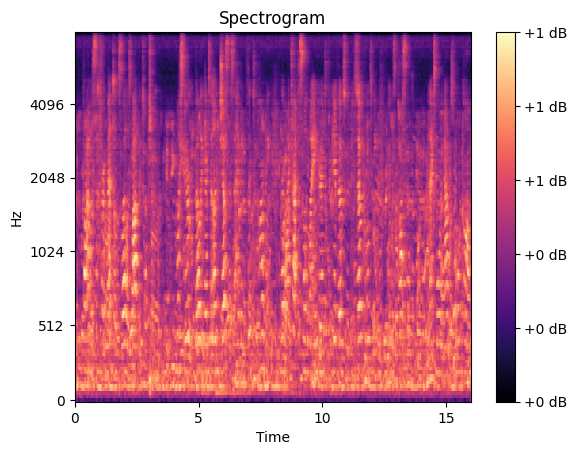

In [27]:
librosa.display.specshow(X_test[2], sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

In [28]:
input_shape = (128, 501, 1)
# input_shape = (X_train[0].shape[0], X_train[0].shape[1], 1)
rs = (int(128 * 2 / 3), int(501 * 2 / 3))
model = tf.keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(rs[0], rs[1]),
    # layers.MaxPooling2D(pool_size=(3, 3)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    # layers.MaxPooling2D(pool_size=(3, 3)),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 85, 334, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 83, 332, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 110, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 108, 32)       18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 12, 54, 32)        0

In [29]:
# Thiết lập siêu tham số
# model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Huấn luyện mô hình
# history = model.fit(np.array(X_train), np.array(cate_train[:5000]), batch_size=32, epochs=10, validation_data=(np.array(X_test), np.array(cate_test[:200])))


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    # loss='BinaryCrossentropy',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 20


In [ ]:
step = 0
his = []
while step < 24:
    duoi = 500 * step
    tren = 500 * (step + 1)
    step += 1
    X_train = [load(i) for i in speech_train[duoi:tren]]
    history = model.fit(
    np.array(X_train), np.array(cate_train[duoi:tren]),
    # X_train, y_train,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, 
                                               patience=5,
                                               restore_best_weights=True
                                              ), 
    validation_data=[np.array(X_test), np.array(cate_test[:200])]
    # validation_data=[X_test, y_test]
    )
    his.append(history)

Epoch 1/20
16/16 [==============================] - 28s 2s/step - loss: 1.4576 - accuracy: 0.2600 - val_loss: 1.4104 - val_accuracy: 0.2100
Epoch 2/20
16/16 [==============================] - 24s 1s/step - loss: 1.3875 - accuracy: 0.3100 - val_loss: 1.3872 - val_accuracy: 0.2100
Epoch 3/20
16/16 [==============================] - 26s 2s/step - loss: 1.3603 - accuracy: 0.3160 - val_loss: 1.3673 - val_accuracy: 0.2250
Epoch 4/20
16/16 [==============================] - 25s 2s/step - loss: 1.3225 - accuracy: 0.3500 - val_loss: 1.3635 - val_accuracy: 0.3300
Epoch 5/20
16/16 [==============================] - 24s 1s/step - loss: 1.3035 - accuracy: 0.4020 - val_loss: 1.3451 - val_accuracy: 0.4000
Epoch 6/20
16/16 [==============================] - 25s 2s/step - loss: 1.2823 - accuracy: 0.4420 - val_loss: 1.3137 - val_accuracy: 0.4250
Epoch 7/20
16/16 [==============================] - 23s 1s/step - loss: 1.1964 - accuracy: 0.4880 - val_loss: 1.2580 - val_accuracy: 0.4650
Epoch 8/20
16/16 [==

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'])
plt.legend(['loss'])
plt.show()

In [ ]:
plt.plot(history.epoch, metrics['accuracy'])
plt.legend(['accuracy'])
plt.show()

In [ ]:
loss, accuracy = model.evaluate(np.array(X_test), np.array(cate_test[:200]), verbose=0)
print(f' Model loss on the test set: {loss}')
print(f' Model accuracy on the test set: {100*accuracy}')

===================

In [ ]:
input_shape = (128, 501, 1)
# input_shape = (X_train[0].shape[0], X_train[0].shape[1], 1)
rs = (int(128 * 2 / 3), int(501 * 2 / 3))
model1 = tf.keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(rs[0], rs[1]),
    # layers.MaxPooling2D(pool_size=(3, 3)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    # layers.MaxPooling2D(pool_size=(3, 3)),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2)
])
model1.summary()

In [ ]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    # loss='BinaryCrossentropy',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 10
history = model1.fit(
    np.array(X_train), np.array(distant_train[duoi:tren]),
    # X_train, y_train,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, 
                                               patience=5,
                                               restore_best_weights=True
                                              ), 
    validation_data=[np.array(X_test), np.array(distant_test[:200])]
    # validation_data=[X_test, y_test]
)

In [ ]:
step = 0
his1 = []
while step < 24:
    duoi = 500 * step
    tren = 500 * (step + 1)
    step += 1
    X_train = [load(i) for i in speech_train[duoi:tren]]
    history = model1.fit(
    np.array(X_train), np.array(distant_train[duoi:tren]),
    # X_train, y_train,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, 
                                               patience=5,
                                               restore_best_weights=True
                                              ), 
    validation_data=[np.array(X_test), np.array(distant_test[:200])]
    # validation_data=[X_test, y_test]
    )
    his1.append(history)